In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import pickle
import cv2
import tensorflow as tf

In [3]:
from keras.utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

## Load dataset

In [5]:
data_path = "/data/CamVid/"

train_path = "/data/CamVid/train/"
train_label_path = "/data/CamVid/trainannot/"

valid_path = "/data/CamVid/val/"
valid_label_path = "/data/CamVid/valannot/"

test_path = "/data/CamVid/test/"
test_label_path = "/data/CamVid/testannot/"

train_file = data_path + "train.p"
valid_file = data_path + "val.p"
test_file = data_path + "test.p"


In [6]:
with open(train_file, "rb") as f:
    X_train, y_train = pickle.load(f)
with open(valid_file, "rb") as f:
    X_val, y_val = pickle.load(f)
with open(test_file, "rb") as f:
    X_test, y_test = pickle.load(f)

In [7]:
X_train.shape, y_train.shape

((367, 360, 480, 3), (367, 360, 480, 12))

In [8]:
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((468, 360, 480, 3),
 (468, 360, 480, 12),
 (233, 360, 480, 3),
 (233, 360, 480, 12))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f02e94fa588>,
 (-0.5, 479.5, 359.5, -0.5))

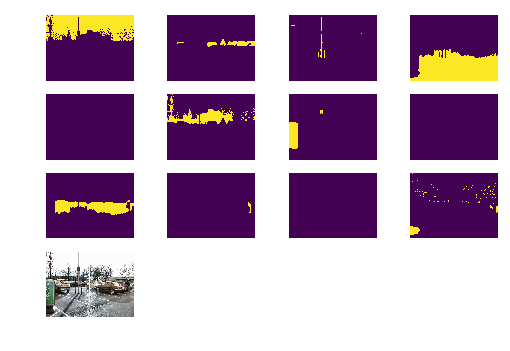

In [10]:
from matplotlib.gridspec import GridSpec
from random import randint, sample
ranidx = randint(0, len(y_train))
gs = GridSpec(4,4)
plt.figure(dpi=100)
for i in range(4*3):
    plt.subplot(gs[i]), plt.imshow(y_train[ranidx][:,:,i]), plt.axis('off')
    
plt.subplot(gs[12]), plt.imshow(X_train[ranidx]), plt.axis('off')

## Build Model

In [15]:
class_weighting= [0.2595, 0.1826, 4.5640, 0.1417, 0.9051, 0.3826, 9.6446, 1.8418, 0.6823, 6.2478, 7.3614, 1.0974]

In [16]:
model_checkpoint = ModelCheckpoint('model-epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True)
model_earlystopping = EarlyStopping(monitor='val_loss')

### Unet

In [ ]:
num_classes = 12
input_shape = X_train.shape[1:] #(480,480,3)
smooth = 1.
nproc = 8
nb_epoch = 200
parallel=True

In [ ]:
from models.unet import unet

In [ ]:
model, single_model = unet(nb_classes=12, input_shape=input_shape)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=8*nproc,
                    epochs=nb_epoch,
                    verbose=1,
                    shuffle=True,
                    validation_split=0.2,
                    class_weight=class_weighting)#, callbacks=[model_checkpoint])

In [ ]:
fig = plt.figure(figsize=(15, 5))
acc = fig.add_subplot(1, 2, 1)
acc.plot(range(1, nb_epoch+1), history.history['dice_coef'], label='train')
acc.plot(range(1, nb_epoch+1), history.history['val_dice_coef'], label='val')
acc.set_xlabel('Epoch', fontsize=18)
acc.set_ylabel('Accuracy', fontsize=16)
acc.legend()
loss = fig.add_subplot(1, 2, 2)
loss.plot(range(1, nb_epoch+1), history.history['loss'], label='train')
loss.plot(range(1, nb_epoch+1), history.history['val_loss'], label='val')
loss.set_xlabel('Epoch', fontsize=18)
loss.set_ylabel('Loss', fontsize=16)
loss.legend()
plt.show()

## Prdict Unet

In [ ]:
pred = model.predict(X_test, verbose=1)

ranidx = randint(0, len(y_test))
gs = GridSpec(1,12)
plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(pred[ranidx][:,:,i], cmap='jet'), plt.axis('off')

plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(y_test[ranidx][:,:,i],cmap='jet'), plt.axis('off')
    
plt.figure(),plt.imshow(X_test[ranidx]), plt.axis('off')

In [ ]:
# refer from : https://github.com/preddy5/segnet/blob/master/Segnet.ipynb
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
#     for l in range(0,11):
#         r[temp==l]=label_colours[l,0]
#         g[temp==l]=label_colours[l,1]
#         b[temp==l]=label_colours[l,2]

    for l in [0, 3, 4, 8, 9, 10]:
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

randsample = sample(range(0,len(pred)), 5)
gs = GridSpec(3,5)
plt.figure(dpi=200)

for i in range(5):
    output = visualize(np.argmax(pred[randsample[i]],axis=2).reshape((360,480)), plot=False)
    out_test = visualize(np.argmax(y_test[randsample[i]],axis=2).reshape((360,480)), plot=False)
        
    plt.subplot(gs[i]), plt.imshow(X_test[randsample[i]]), plt.axis('off')
    plt.subplot(gs[5+i]), plt.imshow(output), plt.axis('off')
    plt.subplot(gs[10+i]), plt.imshow(out_test), plt.axis('off')
    

### SegNet

In [17]:
num_classes = 12
input_shape = X_train.shape[1:] #(480,480,3)
smooth = 1.
nproc = 8
nb_epoch = 200
parallel=True

In [18]:
from models.segnet import segnet

In [19]:
model, single_model = segnet(nb_classes=12, input_shape=input_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 360, 480, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 360, 480, 64)      1792      
_________________________________________________________________
batch_normalization_21 (Batc (None, 360, 480, 64)      256       
_________________________________________________________________
activation_21 (Activation)   (None, 360, 480, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 360, 480, 64)      36928     
_________________________________________________________________
batch_normalization_22 (Batc (None, 360, 480, 64)      256       
_________________________________________________________________
activation_22 (Activation)   (None, 360, 480, 64)      0         
__________

In [21]:
history = model.fit(X_train, y_train,
                    batch_size=6*nproc,
                    epochs=nb_epoch,
                    verbose=1,
                    shuffle=True,
                    validation_split=0.2,
                    class_weight=class_weighting)#, callbacks=[model_checkpoint])

Train on 374 samples, validate on 94 samples
Epoch 1/200
374/374 [==============================] - 25s 67ms/step - loss: 1.3473 - acc: 0.6431 - val_loss: 11.4635 - val_acc: 0.1570
Epoch 2/200
374/374 [==============================] - 20s 53ms/step - loss: 1.0531 - acc: 0.7018 - val_loss: 4.9008 - val_acc: 0.1248
Epoch 3/200
374/374 [==============================] - 20s 52ms/step - loss: 0.9442 - acc: 0.7218 - val_loss: 4.5631 - val_acc: 0.3796
Epoch 4/200
374/374 [==============================] - 20s 54ms/step - loss: 0.8692 - acc: 0.7355 - val_loss: 4.1863 - val_acc: 0.3825
Epoch 5/200
374/374 [==============================] - 20s 55ms/step - loss: 0.8362 - acc: 0.7394 - val_loss: 2.7584 - val_acc: 0.3716
Epoch 6/200
374/374 [==============================] - 19s 52ms/step - loss: 0.7868 - acc: 0.7541 - val_loss: 2.3507 - val_acc: 0.4260
Epoch 7/200
374/374 [==============================] - 20s 52ms/step - loss: 0.7396 - acc: 0.7708 - val_loss: 1.5520 - val_acc: 0.5636
Epoch 8/2

Epoch 61/200
374/374 [==============================] - 20s 55ms/step - loss: 0.2764 - acc: 0.9112 - val_loss: 0.3615 - val_acc: 0.8865
Epoch 62/200
374/374 [==============================] - 20s 53ms/step - loss: 0.2690 - acc: 0.9139 - val_loss: 0.3612 - val_acc: 0.8856
Epoch 63/200
374/374 [==============================] - 20s 53ms/step - loss: 0.2704 - acc: 0.9126 - val_loss: 0.3149 - val_acc: 0.9050
Epoch 64/200
374/374 [==============================] - 21s 55ms/step - loss: 0.2634 - acc: 0.9153 - val_loss: 0.3329 - val_acc: 0.8966
Epoch 65/200
374/374 [==============================] - 20s 53ms/step - loss: 0.2529 - acc: 0.9181 - val_loss: 0.3289 - val_acc: 0.8973
Epoch 66/200
374/374 [==============================] - 19s 52ms/step - loss: 0.2480 - acc: 0.9196 - val_loss: 0.3159 - val_acc: 0.9060
Epoch 67/200
374/374 [==============================] - 20s 54ms/step - loss: 0.2497 - acc: 0.9187 - val_loss: 0.3224 - val_acc: 0.9033
Epoch 68/200
374/374 [==========================

374/374 [==============================] - 20s 53ms/step - loss: 0.1317 - acc: 0.9518 - val_loss: 0.2600 - val_acc: 0.9270
Epoch 122/200
374/374 [==============================] - 20s 54ms/step - loss: 0.1289 - acc: 0.9530 - val_loss: 0.3844 - val_acc: 0.8873
Epoch 123/200
374/374 [==============================] - 19s 52ms/step - loss: 0.1254 - acc: 0.9539 - val_loss: 0.3034 - val_acc: 0.9119
Epoch 124/200
374/374 [==============================] - 20s 53ms/step - loss: 0.1241 - acc: 0.9543 - val_loss: 0.2683 - val_acc: 0.9173
Epoch 125/200
374/374 [==============================] - 20s 54ms/step - loss: 0.1321 - acc: 0.9520 - val_loss: 0.3056 - val_acc: 0.9116
Epoch 126/200
374/374 [==============================] - 21s 55ms/step - loss: 1.5263 - acc: 0.6537 - val_loss: 15.9821 - val_acc: 0.0084
Epoch 127/200
374/374 [==============================] - 20s 54ms/step - loss: 1.2240 - acc: 0.6486 - val_loss: 11.3808 - val_acc: 0.2939
Epoch 128/200
374/374 [==============================

Epoch 181/200
374/374 [==============================] - 20s 54ms/step - loss: 0.3480 - acc: 0.8895 - val_loss: 0.3840 - val_acc: 0.8833
Epoch 182/200
374/374 [==============================] - 20s 53ms/step - loss: 0.3389 - acc: 0.8922 - val_loss: 0.4040 - val_acc: 0.8659
Epoch 183/200
374/374 [==============================] - 21s 56ms/step - loss: 0.3353 - acc: 0.8930 - val_loss: 0.4649 - val_acc: 0.8589
Epoch 184/200
374/374 [==============================] - 20s 54ms/step - loss: 0.3285 - acc: 0.8955 - val_loss: 0.4009 - val_acc: 0.8731
Epoch 185/200
374/374 [==============================] - 20s 54ms/step - loss: 0.3316 - acc: 0.8947 - val_loss: 0.3826 - val_acc: 0.8769
Epoch 186/200
374/374 [==============================] - 21s 55ms/step - loss: 0.3251 - acc: 0.8961 - val_loss: 0.4700 - val_acc: 0.8525
Epoch 187/200
374/374 [==============================] - 20s 53ms/step - loss: 0.3249 - acc: 0.8962 - val_loss: 0.4055 - val_acc: 0.8704
Epoch 188/200
374/374 [==================

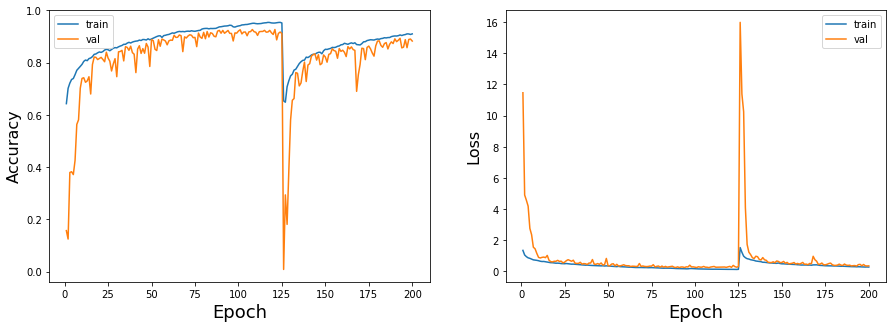

In [22]:
fig = plt.figure(figsize=(15, 5))
acc = fig.add_subplot(1, 2, 1)
acc.plot(range(1, nb_epoch+1), history.history['acc'], label='train')
acc.plot(range(1, nb_epoch+1), history.history['val_acc'], label='val')
# acc.plot(range(1, 100+1), history.history['acc'], label='train')
# acc.plot(range(1, 100+1), history.history['val_acc'], label='val')

acc.set_xlabel('Epoch', fontsize=18)
acc.set_ylabel('Accuracy', fontsize=16)
acc.legend()
loss = fig.add_subplot(1, 2, 2)
loss.plot(range(1, nb_epoch+1), history.history['loss'], label='train')
loss.plot(range(1, nb_epoch+1), history.history['val_loss'], label='val')
# loss.plot(range(1, 100+1), history.history['loss'], label='train')
# loss.plot(range(1, 100+1), history.history['val_loss'], label='val')
loss.set_xlabel('Epoch', fontsize=18)
loss.set_ylabel('Loss', fontsize=16)
loss.legend()
plt.show()

## Predict SegNet model

233/233 [==============================] - 7s 31ms/step


(<matplotlib.figure.Figure at 0x7efaa82d66d8>,
 (-0.5, 479.5, 359.5, -0.5))

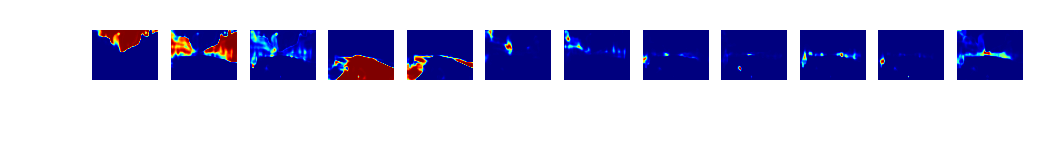

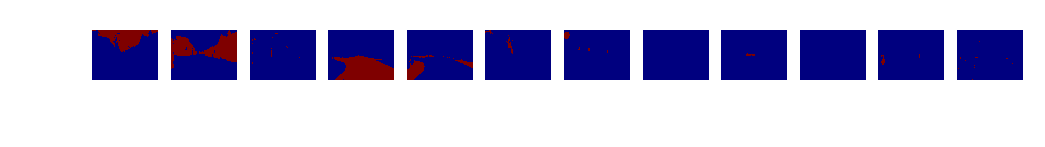

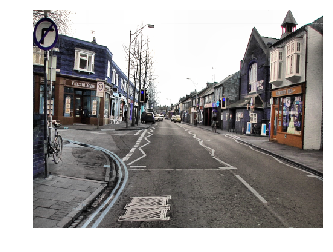

In [23]:
pred = model.predict(X_test, verbose=1)

ranidx = randint(0, len(y_test))
gs = GridSpec(1,12)
plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(pred[ranidx][:,:,i], cmap='jet'), plt.axis('off')

plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(y_test[ranidx][:,:,i],cmap='jet'), plt.axis('off')
    
plt.figure(),plt.imshow(X_test[ranidx]), plt.axis('off')

## Visualize

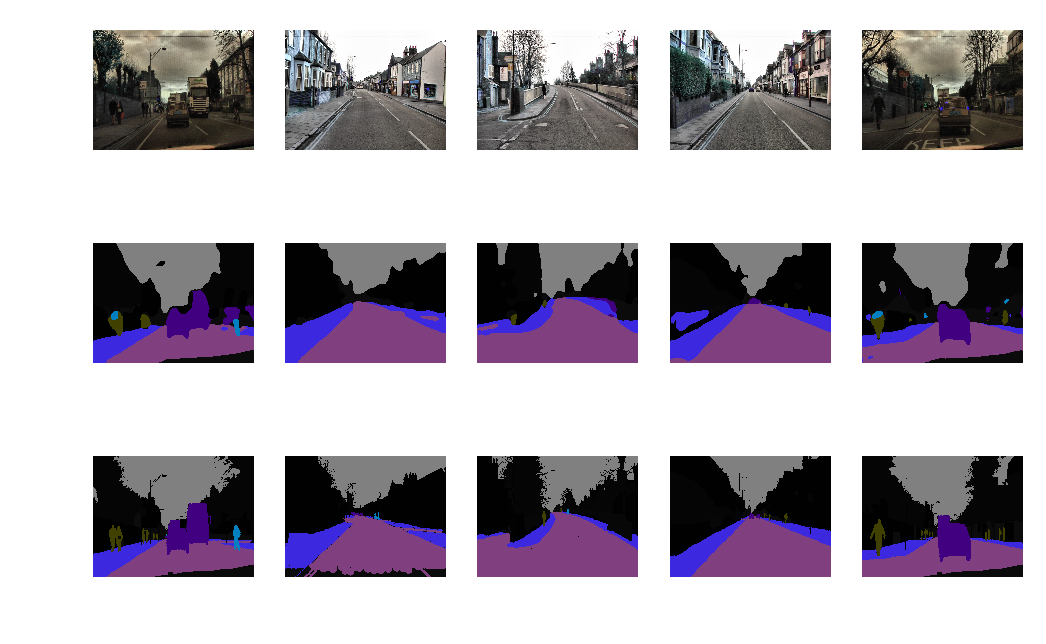

In [24]:
# refer from : https://github.com/preddy5/segnet/blob/master/Segnet.ipynb
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
#     for l in range(0,11):
#         r[temp==l]=label_colours[l,0]
#         g[temp==l]=label_colours[l,1]
#         b[temp==l]=label_colours[l,2]

    for l in [0, 3, 4, 8, 9, 10]:
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

randsample = sample(range(0,len(pred)), 5)
gs = GridSpec(3,5)
plt.figure(dpi=200)

for i in range(5):
    output = visualize(np.argmax(pred[randsample[i]],axis=2).reshape((360,480)), plot=False)
    out_test = visualize(np.argmax(y_test[randsample[i]],axis=2).reshape((360,480)), plot=False)
        
    plt.subplot(gs[i]), plt.imshow(X_test[randsample[i]]), plt.axis('off')
    plt.subplot(gs[5+i]), plt.imshow(output), plt.axis('off')
    plt.subplot(gs[10+i]), plt.imshow(out_test), plt.axis('off')
    